In [206]:
import pandas as pd

In [207]:
df=pd.read_csv("../combined_data.csv")

In [208]:
df.drop(columns="Unnamed: 0",inplace=True)

In [209]:
df.describe()

,salary_lpa,company_rating
count,15290.000000,15290.000000
mean,14.919779,2.484166
std,30.621419,1.929593
min,0.060000,0.000000
25%,4.500000,0.000000
50%,6.571429,3.500000
75%,12.610857,4.000000
max,1200.960000,5.000000


In [210]:
df.isnull().sum()

company_name               0
job_role                   0
job_location               0
salary_lpa                 0
skills                   369
company_rating             0
standardized_job_role      0
dtype: int64

### Mapping job location on map

In [212]:
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
L=pd.read_csv("../latitude_ longitud_of _cities_in_india.csv")


In [213]:

df['job_location'] = df['job_location'].str.lower()
L['city'] = L['city'].str.lower()
s="Jobs"
# Merge df with L to get lat and lng
merged_df = pd.merge(df, L, left_on='job_location', right_on='city', how='left')

# Add India's lat/lng for "remote"
merged_df.loc[merged_df['job_location'] == 'remote', ['lat', 'lng']] = [20.5937, 78.9629]

# Drop rows where lat/lng is missing
merged_df = merged_df.dropna(subset=['lat', 'lng'])

# Count occurrences of each location
location_counts = merged_df['job_location'].value_counts()

# Create a base map centered around India
base_map = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

# Add markers for each job location with counts
for location, count in location_counts.items():
    # Get latitude and longitude for the location
    lat = merged_df.loc[merged_df['job_location'] == location, 'lat'].iloc[0]
    lng = merged_df.loc[merged_df['job_location'] == location, 'lng'].iloc[0]
    
    # Add a regular marker
    folium.Marker(
        location=[lat, lng],
        popup=f"{location.title()} ({count} jobs)"
    ).add_to(base_map)
    
    # Add the count above the marker using a DivIcon
    folium.map.Marker(
        [lat + 0.02, lng],  # Adjust position slightly above the marker
        icon=folium.DivIcon(
            # html=f'<div style="font-size: 16px; color: black; text-align: center;">{str(count)+"Jobs}</div>'
f'''
<div style="text-align: center;">
    <span style="font-size: 17px; color: blue; line-height: 1;">{count}</span>
</div>
'''
        )
    ).add_to(base_map)

# Save the map to an HTML file
base_map.save("job_locations_map.html")

### Analysis of Skill in demand for tech jobs

In [214]:

df['skills'] = df['skills'].str.lower().str.split(', ')  
all_skills = [skill for sublist in df['skills'].dropna() for skill in sublist]


In [215]:
from collections import Counter


skill_counts = Counter(all_skills)


skill_df = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Count'])


skill_df = skill_df.sort_values(by='Count', ascending=False)
print(skill_df)


                           Skill  Count
238                          css   2756
10                         react   2280
45                         azure   1820
176                          git   1686
205                      node.js   1531
..                           ...    ...
776  microsoft dynamics navision      1
574            anatomy knowledge      1
579                        yardi      1
770                      chinese      1
885                       zeplin      1

[886 rows x 2 columns]


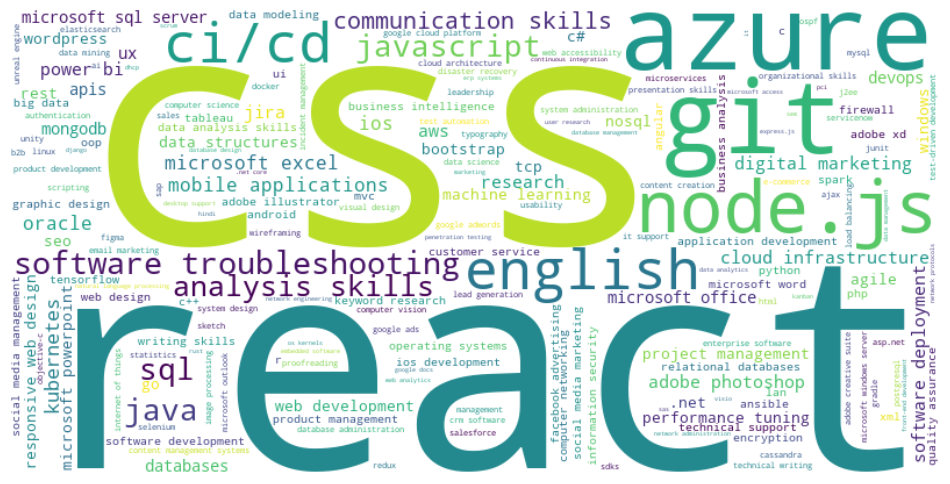

In [216]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(skill_counts)
# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.show()


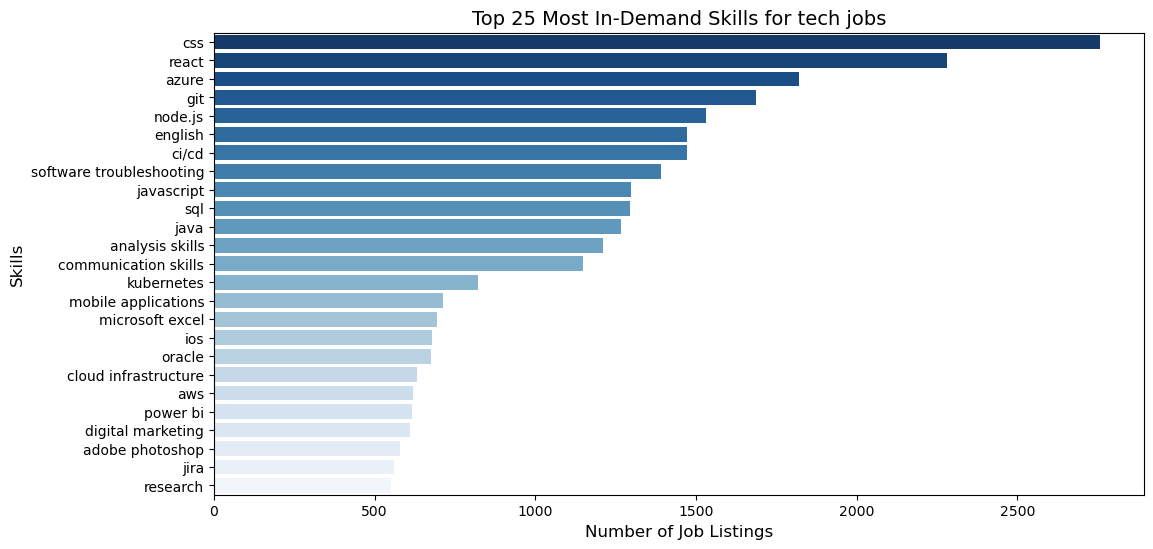

In [217]:
import seaborn as sns
top_skills = skill_df.head(25)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_skills['Count'], y=top_skills['Skill'], palette="Blues_r")

plt.title(f"Top 25 Most In-Demand Skills for tech jobs", fontsize=14)
plt.xlabel("Number of Job Listings", fontsize=12)
plt.ylabel("Skills", fontsize=12)
plt.show()


### Number of jobs on different location

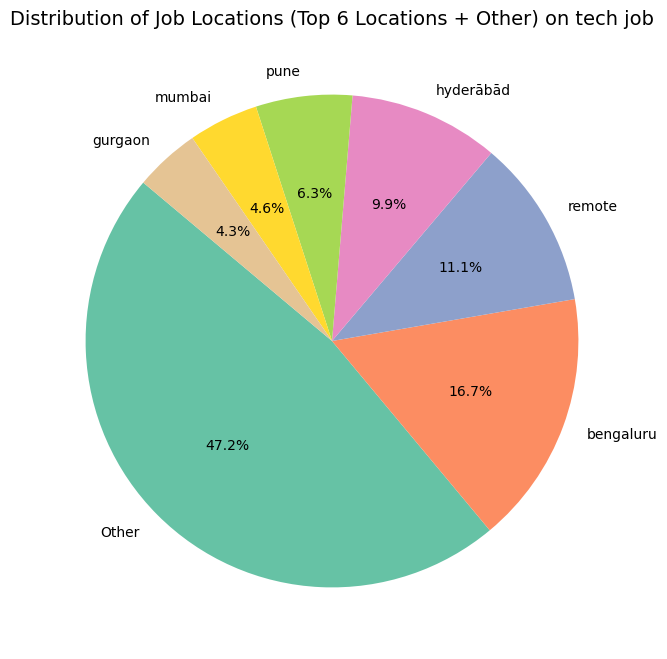

In [218]:
# Calculate the frequency of each location, excluding 'India'
location_counts = df[df['job_location'] != 'india']['job_location'].value_counts()

# Get the top 6 most frequent locations
top_locations = location_counts.head(6).index

# Group 'India' and other locations as 'Other'
df['job_location_grouped'] = df['job_location'].apply(lambda x: x if x in top_locations else 'Other')

# Calculate the frequency of the grouped locations
location_grouped_counts = df['job_location_grouped'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(location_grouped_counts, labels=location_grouped_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2", len(location_grouped_counts)))

# Set the title
plt.title(f"Distribution of Job Locations (Top 6 Locations + Other) on tech job", fontsize=14)

# Show the pie chart
plt.show()

### Number of jobs Available for Different Catgo

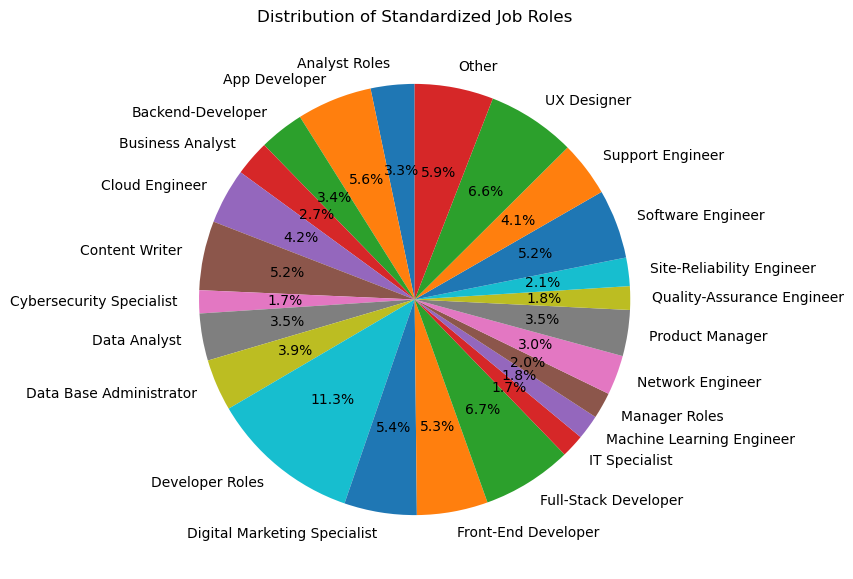

In [228]:
# Group by "standardized_job_role" and count the number of rows
grouped = df.groupby("standardized_job_role").size()

# Handle roles with less than 1%
total = grouped.sum()
grouped = pd.concat([
    grouped[grouped / total >= 0.015],
    pd.Series({"Other": grouped[grouped / total < 0.015].sum()})
])

# Plot pie chart
grouped.plot(kind="pie", autopct="%1.1f%%", startangle=90, figsize=(7, 7))
plt.title("Distribution of Standardized Job Roles")
plt.ylabel("")  # Hide the y-label for better visuals
plt.show()
